## Mangrove Project: Predict Correlations in Factors

In [1]:
# load packages and modules
date = '_2020'
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import colors as c
from matplotlib import cm
import pandas as pd
import os
#import pickle
#import time
#import random
from sklearn.neighbors.kde import KernelDensity
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
from scipy import interpolate as interpolate
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot

main_dir = os.getcwd()

os.chdir(main_dir + '/PFILES/')
from plot_calc_load_funcs import *

# load RSL (GIA) data
os.chdir(main_dir + '/IFILES/')

pgia = load_pickle("pgia_all.pkl")
giamods = load_pickle("modrange.pkl")
nages = load_pickle("nages.pkl")
#points_latlon = load_pickle("points_latlon.pkl")


# Mangrove data
df = pd.read_csv('MangroveCorrData.csv')
lat = df['Latitude'].values
lon = df['Longitude'].values
tide_class = df['Type'].values
geo_set = df['Geomorphic setting'].values

el_age = df['end4'].values
ef_age = df['end1'].values
age_beg1 = df['beg1'].values
bf_age = age_beg1
age_beg2 = df['beg2'].values
age_beg3 = df['beg3'].values
age_beg4 = df['beg4'].values
age_begmid = np.empty(age_beg1.shape)
age_begmid = np.nanmean([age_beg1, age_beg4], axis=0)+300
bl_age = age_beg4+300
bf_age = age_beg1+300

accret_rate = df['Rate (mm yr-1)'].values.reshape([122,1])
prox = -(df['intermediate-Field'].values - 1).reshape([122,1])
tide_class = df['Type'].values.reshape([122,1])
geo_set = df['Geomorphic setting'].values.reshape([122,1])

dir = os.path.join(main_dir, date)
if not os.path.exists(dir):
    os.mkdir(dir)
os.chdir(dir)

# define ages with RSL data, color map, dates to predict and Earth parameters of models
ages = np.arange(12.5, -.5, -.5)
cmap1 = cm.get_cmap("viridis")
testt = np.arange(0, 12.6, .1)
gia_param_names = ['lt', 'umv', 'lmv']
# subtract RSL prediction at time 0 to adjust to present for each model
pgia1 = np.empty(pgia.shape)
for ii in range(len(ages)):
    pgia1[:, :, ii] = pgia[:, :, ii] - pgia[:, :, -1]

/Users/ericaashe/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


### Regress accretion Initiation Date AND Vertical Accretion Rate on RSLR Rate
#### Find average rate of RSLR at the mean time of accretion (average when accretion rates are calculated for equivalence)

In [2]:
sel_acc = np.squeeze(np.where(df['intermediate-Field'] < 2))

pgia_acc = pgia1[:, np.squeeze(sel_acc), :]
#np.nanmean(rates[:, xx, 1])
age_ave = 200
age_per = 100
#age_ave = 300
#age_per = 100

rates0, ages_acc = calculate_lin_gia_rates(pgia_acc, ages, age_ave, age_per)
pareind = int(np.squeeze(np.where(df['Location']=='Pare Pare Indonesia')))
rates_acc = rates0
rates_acc[:, 18, :] = rates0[:, pareind, :] - 1.38

# interpolate and average the models for the average accretion time (acc_dates):
arb1 = df['b_acc_rate1'].values
arb2 = df['b_acc_rate2'].values
are1 = df['e_acc_rate1'].values
are2 = df['e_acc_rate2'].values

acc_dates = np.nanmean((arb1,arb2,are1,are2), axis = 0)


/Users/ericaashe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice


In [3]:
accret_rate = df['Rate (mm yr-1)'].values.reshape([122,1])
prox = -(df['intermediate-Field'].values - 1).reshape([122,1])
tide_class = df['Type'].values.reshape([122,1])
#tide_class = df['Type'].values.reshape([122,1])
#tc = np.ndarray
geo_set = df['Geomorphic setting'].values.reshape([122,1])


In [4]:
tc = np.where(tide_class=='microtidal', np.repeat(1, len(tide_class)).reshape(len(tide_class),1), \
              np.where(tide_class=='macrotidal', np.repeat(3, len(tide_class)).reshape(len(tide_class),1),\
                       np.repeat(2, len(tide_class)).reshape(len(tide_class),1)))
gs = np.where(geo_set=='Marine embayment', np.repeat(1, len(tide_class)).reshape(len(tide_class),1), \
              np.where(geo_set=='Riverine estuary', np.repeat(2, len(tide_class)).reshape(len(tide_class),1),\
              np.where(geo_set=='Calcareous', np.repeat(3, len(tide_class)).reshape(len(tide_class),1),\
              np.where(geo_set=='Tidal estuary', np.repeat(4, len(tide_class)).reshape(len(tide_class),1),\
              #np.where(tide_class=='Barrier estuary', np.repeat(3, len(tide_class)).reshape(len(tide_class),1),\
              np.repeat(5, len(tide_class)).reshape(len(tide_class),1)))))

In [5]:
int_obj = {}
rsl_rate_at_acc = np.empty(len(acc_dates))
acc_dates[np.where(acc_dates<min(ages_acc))]=min(ages_acc)
for ii in arange(len(rates_acc[0,:,0])):
    int_obj[ii] = interp1d(ages_acc, np.nanmean(rates_acc[:,ii,:], axis = 0), kind = 'linear')
    rsl_rate_at_acc[ii] =  int_obj[ii](acc_dates[ii])
nonnan = np.where(isnan(rsl_rate_at_acc)==0)
rsl_rate = rsl_rate_at_acc[nonnan]
acc_rate = accret_rate[nonnan]
proxim = prox[nonnan]
geo = geo_set[nonnan]
tidr = tide_class[nonnan]
accd = acc_dates[nonnan]

gsn = np.squeeze(gs)[nonnan]
tcn = np.squeeze(tc)[nonnan]
#print(ind_var0)
ind_var0 = np.column_stack(( rsl_rate, gsn, tcn, proxim))#, gs3, age_begmid, tc*prox, tc*gs1, tc*gs2, tc*gs3, prox*gs1,\
                           #prox*gs2, prox*gs3))
ind_var1 = np.column_stack((gsn, tcn, proxim))
#ind_var0 = np.concatenate((rsl_rate,geo, tidr, proxim),axis = 1)
#ind_var =  sm.add_constant(ind_var0, prepend=False)
dep_var = np.squeeze(accd)

/Users/ericaashe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


### Linear regression of Accretion Rate on RSLR

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     126.5
Date:                Mon, 17 Aug 2020   Prob (F-statistic):           2.18e-20
Time:                        12:06:59   Log-Likelihood:                -219.62
No. Observations:                 120   AIC:                             443.2
Df Residuals:                     118   BIC:                             448.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0452      0.093     11.247      0.0

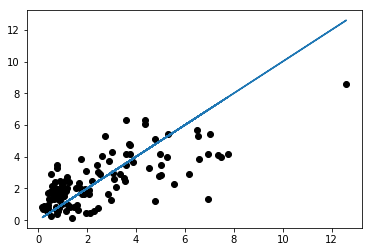

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
y = acc_rate
X = rsl_rate.reshape(-1, 1)

reg = LinearRegression().fit(X, y)
# Make predictions using the testing set
y_pred = reg.predict(X)
#plt.scatter(y, y_pred,  color='black')
#plt.plot(y,y)


#plt.plot(X, y_pred, color='blue', linewidth=3)
#plt.ylabel('Mangrove Accretion Rates (mm/yr)')
#plt.xlabel('RSL Rate (mm/yr) at Average Date of Accretion')
#plt.savefig('Accretion Date by RSLR, Geo, Linear Regression' + date + '.pdf')

X0 = sm.add_constant(X, prepend=False)
model = sm.OLS(y, X0).fit()
predictions = model.predict(X0) # make the predictions by the model
print(model.summary())
r2_score(y,predictions)
plt.scatter(y, predictions,  color='black')
plt.plot(y,y)
print(r2_score(y,predictions))


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  120
Model:                            GLM   Df Residuals:                      118
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          2.3148
Method:                          IRLS   Log-Likelihood:                -219.62
Date:                Mon, 17 Aug 2020   Deviance:                       273.15
Time:                        12:07:03   Pearson chi2:                     273.
No. Iterations:                     3   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0452      0.093     11.247      0.000       0.863       1.227
const          1.3110      0.170      7.703      0.0

0.5173509000961252

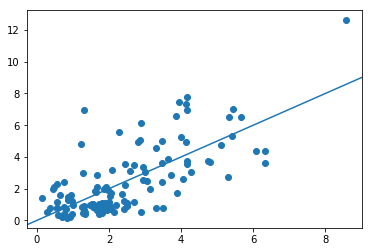

In [7]:
glm0 = sm.GLM(y, X0, family=sm.families.Gaussian())
              #%Poisson(link=sm.families.links.log))
res0 = glm0.fit()
print(res0.summary())
yhat0 = res0.mu
fig0, ax0 = plt.subplots()
ax0.scatter(yhat0,y)

line_fit = sm.OLS(y, sm.add_constant(yhat0, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax0)

r2_score(y,yhat0)

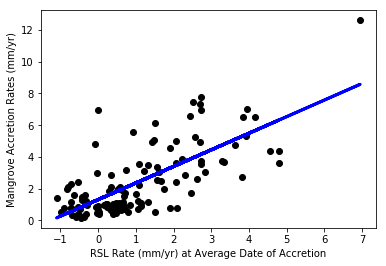

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
y = acc_rate
X = rsl_rate.reshape(-1, 1)
reg = LinearRegression().fit(X, y)
# Make predictions using the testing set
y_pred = reg.predict(X)
plt.scatter(X, y,  color='black')
plt.plot(X, y_pred, color='blue', linewidth=3)
plt.ylabel('Mangrove Accretion Rates (mm/yr)')
plt.xlabel('RSL Rate (mm/yr) at Average Date of Accretion')

plt.savefig('Accretion Rate by RSLR Linear Regression' + date + '.pdf')

### Now regress RSLR on geomorphic setting, tidal range, and proximity

In [9]:
## regress accretion rate (accret_rate) on geomorphic setting (geo_set), tide type (tide_class), and proximity to former ice sheet (prox)
## accret_rate is continuous (ranges from 0.17 to 12.6 mm/yr)
## geo_set is categorical with five categories: 'Barrier estuary', 'Calcareous', 'Marine embayment', 'Riverine estuary', 'Tidal estuary'
## tide_class is categorical with three categories: 'macrotidal', 'mesotidal', 'microtidal'
## prox is categorical with 0 = intermediate-field (1 = far-field) to former ice sheet 

tc = np.where(tide_class=='microtidal', np.repeat(1, len(tide_class)).reshape(len(tide_class),1), \
              np.where(tide_class=='macrotidal', np.repeat(3, len(tide_class)).reshape(len(tide_class),1),\
                       np.repeat(2, len(tide_class)).reshape(len(tide_class),1)))
gs = np.where(geo_set=='Marine embayment', np.repeat(1, len(tide_class)).reshape(len(tide_class),1), \
              np.where(geo_set=='Riverine estuary', np.repeat(2, len(tide_class)).reshape(len(tide_class),1),\
              np.where(geo_set=='Calcareous', np.repeat(3, len(tide_class)).reshape(len(tide_class),1),\
              np.where(geo_set=='Tidal estuary', np.repeat(4, len(tide_class)).reshape(len(tide_class),1),\
              #np.where(tide_class=='Barrier estuary', np.repeat(3, len(tide_class)).reshape(len(tide_class),1),\
              np.repeat(5, len(tide_class)).reshape(len(tide_class),1)))))

gs1 = np.where(geo_set==('Marine embayment'or 'Barrier estuary'), 1, 0)
gs2 = np.where(geo_set==('Barrier estuary' or 'Calcareous' or 'Tidal estuary'),1, 0)
gs3 = np.where(geo_set==('Riverine estuary'or 'Calcareous'), 1, 0)

#tide_class=='microtidal', np.repeat(1, len(tide_class)).reshape(len(tide_class),1), \
#              np.where(tide_class=='macrotidal', np.repeat(3, len(tide_class)).reshape(len(tide_class),1),\
#                       np.repeat(2, len(tide_class)).reshape(len(tide_class),1)))
                       #         np.repeat(0, len(tide_class), 1, 
#dep_var = [accret_rate.reshape(len(accret_rate),1)]
#ind_var = np.concatenate((geo_set, tide_class, prox),axis = 0)
dep_var = np.squeeze(accret_rate)
#dep_var = sm.add_constant(ind_var, prepend=False)
#ind_var = np.concatenate((geo_set, tc, prox),axis = 1)
#ind_var = np.column_stack((age_begmid.reshape(len(age_begmid),1)[where(tc==1)]\#.reshape(len(age_begmid),1),\
#                           (age_begmid.reshape(len(age_begmid),1)[where(tc==0)].reshape(len(age_begmid),1))))
ind_var0 = np.column_stack(( tc, prox, gs1, gs2, gs3, age_begmid, tc*prox, tc*gs1, tc*gs2, tc*gs3, prox*gs1,\
                           prox*gs2, prox*gs3))
ind_var1 = np.column_stack(( tc, prox, gs1, gs2, gs3, tc*prox, tc*gs1, tc*gs2, tc*gs3, prox*gs1,\
                           prox*gs2, prox*gs3))
                           #gs1*gs2, gs2*gs3, gs3*gs4, gs1*gs4))

ind_var =  sm.add_constant(age_begmid, prepend=False)
ind_var1 =  sm.add_constant(ind_var1, prepend=False)
ind_var2 =  np.column_stack(( tc, tc*gs1, prox*gs1, prox*gs2))
ind_var2 =  sm.add_constant(ind_var2, prepend=False)
ind_var_gs = np.column_stack((gs1, gs2, gs3, gs1*gs2, gs2*gs3, gs3*gs1))
ind_var_gs =  sm.add_constant(ind_var_gs, prepend=False)
ind_var_t = sm.add_constant(tc, prepend=False)
ind_var_p = sm.add_constant(prox, prepend=False)
ind_var0 = sm.add_constant(ind_var0, prepend=False)

In [10]:
formula = 'accret_rate ~ tc + prox + geo_set + geo_set*tc + \
    geo_set*prox + tc*prox'

dta = pd.DataFrame({'accret_rate':np.squeeze(accret_rate),'tc':np.squeeze(tc), 'prox':np.squeeze(prox),  'geo_set':np.squeeze(geo_set)})
dta['accret_rate']
mod1 = smf.glm(formula=formula, data=dta, family=sm.families.Gaussian()).fit()
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            accret_rate   No. Observations:                  122
Model:                            GLM   Df Residuals:                      109
Model Family:                Gaussian   Df Model:                           12
Link Function:               identity   Scale:                          4.2273
Method:                          IRLS   Log-Likelihood:                -254.17
Date:                Mon, 17 Aug 2020   Deviance:                       460.77
Time:                        12:07:13   Pearson chi2:                     461.
No. Iterations:                     3   Covariance Type:             nonrobust
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            1.7521      0.580      3.023      0.003       0.616       2.888
geo_set[T.Calcareous]                0.5250      0.297      1.769      0.077      -0.057       1.107
geo_set[T.Marine embayment]          0.9806      1.500      0.654      0.513      -1.959       3.920
geo_set[T.Riverine estuary]          1.2142      1.655      0.734      0.463      -2.030       4.458
geo_set[T.Tidal estuary]            -1.7493      1.000     -1.749      0.080      -3.709       0.211
tc                                  -0.3461      0.580     -0.597      0.550      -1.482       0.790
geo_set[T.Calcareous]:tc             0.5250      0.297      1.769      0.077      -0.057       1.107
geo_set[T.Marine embayment]:tc      -1.0479      1.229     -0.853      0.394      -3.456       1.360
geo_set[T.Riverine estuary]:tc       0.5131      1.058      0.485      0.628      -1.560       2.587
geo_set[T.Tidal estuary]:tc          1.0429      1.176      0.886      0.375      -1.263       3.349
prox                                 2.4140      0.888      2.718      0.007       0.673       4.155
geo_set[T.Calcareous]:prox          -4.0757      1.419     -2.873      0.004      -6.857      -1.295
geo_set[T.Marine embayment]:prox    -1.2110      1.368     -0.885      0.376      -3.893       1.471
geo_set[T.Riverine estuary]:prox    -2.6017      1.640     -1.587      0.113      -5.815       0.612
geo_set[T.Tidal estuary]:prox       -1.7493      1.000     -1.749      0.080      -3.709       0.211
tc:prox                              0.3158      0.430      0.734      0.463      -0.527       1.159
====================================================================================================
"""

In [11]:
formula = 'accret_rate ~ tc + prox + geo_set'
dta = pd.DataFrame({'accret_rate':np.squeeze(accret_rate),'tc':np.squeeze(tc), 'prox':np.squeeze(prox),  'geo_set':np.squeeze(geo_set)})
dta['accret_rate']
mod1 = smf.glm(formula=formula, data=dta, family=sm.families.Gaussian()).fit()
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            accret_rate   No. Observations:                  122
Model:                            GLM   Df Residuals:                      115
Model Family:                Gaussian   Df Model:                            6
Link Function:               identity   Scale:                          4.4460
Method:                          IRLS   Log-Likelihood:                -260.52
Date:                Mon, 17 Aug 2020   Deviance:                       511.29
Time:                        12:07:18   Pearson chi2:                     511.
No. Iterations:                     3   Covariance Type:             nonrobust
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       1.6483      0.578      2.852      0.004       0.516       2.781
geo_set[T.Calcareous]           0.2562      0.542      0.473      0.636      -0.806       1.318
geo_set[T.Marine embayment]    -0.7628      0.590     -1.293      0.196      -1.919       0.394
geo_set[T.Riverine estuary]     0.6779      0.668      1.014      0.310      -0.632       1.988
geo_set[T.Tidal estuary]       -0.7672      0.909     -0.844      0.398      -2.548       1.014
tc                              0.2909      0.398      0.730      0.465      -0.490       1.071
prox                            0.8688      0.527      1.648      0.099      -0.165       1.902
===============================================================================================
"""